# Integrate ClearML

In [1]:
from clearml import Task

In [2]:
task = Task.init(project_name="PCOS Diagnosis", task_name= "CNN")

ClearML Task: created new task id=2c432fc64bc742b1aabc0eb0d737a126
ClearML results page: https://app.clear.ml/projects/f5e21c80429b490ea4443d4f94353224/experiments/2c432fc64bc742b1aabc0eb0d737a126/output/log
ClearML Monitor: GPU monitoring failed getting GPU reading, switching off GPU monitoring
ClearML Monitor: Could not detect iteration reporting, falling back to iterations as seconds-from-start


In [3]:
logger = task.get_logger()

# Importing Necessary Modules

In [5]:
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
plt.style.use("ggplot")
plt.rcParams['figure.figsize'] = (12, 8)
import seaborn as sns
sns.set(style='whitegrid', color_codes=True)
import warnings
warnings.filterwarnings('ignore')
from sklearn.feature_selection import chi2,f_classif, mutual_info_classif, SelectKBest
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import StratifiedKFold
from yellowbrick.model_selection import CVScores
from sklearn.metrics import confusion_matrix

# Load Dataset

In [66]:
df = pd.read_csv('../../datasets/PCOS_clean_data_without_infertility.csv')
df.head(12)

,PCOS (Y/N),Age (yrs),Weight (Kg),Height(Cm),BMI,Blood Group,Pulse rate(bpm),RR (breaths/min),Hb(g/dl),Cycle(R/I),...,Pimples(Y/N),Fast food (Y/N),Reg.Exercise(Y/N),BP _Systolic (mmHg),BP _Diastolic (mmHg),Follicle No. (L),Follicle No. (R),Avg. F size (L) (mm),Avg. F size (R) (mm),Endometrium (mm)
0,0,28,44.6,152.0,19.30,15,78,22,10.48,0,...,0,1.0,0,110,80,3,3,18.0,18.0,8.5
1,0,36,65.0,161.5,24.92,15,74,20,11.70,0,...,0,0.0,0,120,70,3,5,15.0,14.0,3.7
2,1,33,68.8,165.0,25.27,11,72,18,11.80,0,...,1,1.0,0,120,80,13,15,18.0,20.0,10.0
3,0,37,65.0,148.0,29.67,13,72,20,12.00,0,...,0,0.0,0,120,70,2,2,15.0,14.0,7.5
4,0,25,52.0,161.0,20.06,11,72,18,10.00,0,...,0,0.0,0,120,80,3,4,16.0,14.0,7.0
5,0,36,74.1,165.0,27.22,15,78,28,11.20,0,...,0,0.0,0,110,70,9,6,16.0,20.0,8.0
6,0,34,64.0,156.0,26.30,11,72,18,10.90,0,...,0,0.0,0,120,80,6,6,15.0,16.0,6.8
7,0,33,58.5,159.0,23.14,13,72,20,11.00,0,...,0,0.0,0,120,80,7,6,15.0,18.0,7.1
8,0,32,40.0,158.0,16.02,11,72,18,11.80,0,...,0,0.0,0,120,80,5,7,17.0,17.0,4.2
9,0,36,52.0,150.0,23.11,15,80,20,10.00,1,...,0,0.0,0,110,80,1,1,14.0,17.0,2.5


In [67]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 538 entries, 0 to 537
Data columns (total 42 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   PCOS (Y/N)              538 non-null    int64  
 1   Age (yrs)               538 non-null    int64  
 2   Weight (Kg)             538 non-null    float64
 3   Height(Cm)              538 non-null    float64
 4   BMI                     538 non-null    float64
 5   Blood Group             538 non-null    int64  
 6   Pulse rate(bpm)         538 non-null    int64  
 7   RR (breaths/min)        538 non-null    int64  
 8   Hb(g/dl)                538 non-null    float64
 9   Cycle(R/I)              538 non-null    int64  
 10  Cycle length(days)      538 non-null    int64  
 11  Marraige Status (Yrs)   538 non-null    float64
 12  Pregnant(Y/N)           538 non-null    int64  
 13  No. of aborptions       538 non-null    int64  
 14  I   beta-HCG(mIU/mL)    538 non-null    fl

In [68]:
logger.report_table("PCOS Cleaned Dataset", "Original", iteration=0, table_plot=df)

In [69]:
X = df.drop(["PCOS (Y/N)",
            "Blood Group",
            "Height(Cm)",
            "Pregnant(Y/N)",
             "PRG(ng/mL)",
            "RR (breaths/min)",
            "No. of aborptions",
            "FSH/LH",
            "I   beta-HCG(mIU/mL)",
            "II    beta-HCG(mIU/mL)",
            "TSH (mIU/L)",
            "FSH(mIU/mL)",
            "LH(mIU/mL)",
            "Waist:Hip Ratio",
            "PRL(ng/mL)",
            "BP _Diastolic (mmHg)",
            "BP _Systolic (mmHg)",
            "Reg.Exercise(Y/N)",
            "RBS(mg/dl)"
            ],axis=1)

In [70]:
y = df[["PCOS (Y/N)"]]

# Data Augmentation

## Resampling on Complete Dataset

In [71]:
from imblearn.combine import SMOTEENN

resample = SMOTEENN(sampling_strategy="auto", random_state =0)
X, y = resample.fit_resample(X, y)

In [72]:
logger.report_table("PCOS Cleaned Dataset - X", "Over-Under Sampled", iteration=0, table_plot=X)

In [73]:
logger.report_table("PCOS Cleaned Dataset - y", "Over-Under Sampled", iteration=0, table_plot=y)

## Splitting

In [74]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify= y)

In [75]:
X_train, X_dev, y_train, y_dev = train_test_split(X_train, y_train, test_size=0.15, random_state=0, stratify= y_train)

In [76]:
X_train.shape

(325, 23)

In [77]:
X_test.shape

(96, 23)

In [78]:
X_dev.shape

(58, 23)

## Scaling

In [79]:
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler

scaler = MinMaxScaler().fit(X_train)

X_train = scaler.transform(X_train)
X_train = pd.DataFrame(X_train)

X_dev = scaler.transform(X_dev)
X_dev = pd.DataFrame(X_dev)

X_test = scaler.transform(X_test)
X_test = pd.DataFrame(X_test)


# Setting Column Names from dataset
X_train.columns = X.columns
X_test.columns = X.columns
X_dev.columns = X.columns

# CNN

In [80]:
import tensorflow as tf
from tensorflow.keras import datasets, layers, models

In [81]:
X_train = X_train.to_numpy().reshape(X_train.shape[0], X_train.shape[1], 1)

In [82]:
# y_train = y_train.to_numpy().reshape(y_train.shape[0], 1)

In [83]:
X_test = X_test.to_numpy().reshape(X_test.shape[0], X_test.shape[1], 1)

In [84]:
# y_test = y_test.to_numpy().reshape(y_test.shape[0], 1)

In [85]:
X_dev = X_dev.to_numpy().reshape(X_dev.shape[0], X_dev.shape[1], 1)

In [86]:
# y_dev = y_dev.to_numpy().reshape(y_dev.shape[0], 1)

In [87]:
from tensorflow.keras.utils import to_categorical
y_train = to_categorical(y_train, 2)
y_test = to_categorical(y_test, 2)
y_dev = to_categorical(y_dev, 2)

### Hyperparameters Define

In [114]:
parameters = {
    'optimizer': "Adam",
    'epochs': 200,
    'early_stopping_paitence':50,
    'loss': 'binary_crossentropy',
    'metric': ['AUC','accuracy', 'Precision', 'Recall']
}

In [115]:
# Report to ClearML
parameters = task.connect(parameters, name="Hyperparameters")

### Build Model

In [116]:
model = models.Sequential()
model.add(layers.Conv1D(128, (3), activation='relu', input_shape=X_train.shape[1:]))
model.add(layers.Conv1D(64, (3), activation='relu'))
model.add(layers.Conv1D(32, (3), activation='relu'))
model.add(layers.Conv1D(64, (3), activation='relu'))
model.add(layers.Conv1D(64, (5), activation='relu'))
model.add(layers.Conv1D(32, (5), activation='relu'))

In [117]:
model.add(layers.Flatten())
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(128, activation='relu'))
model.add(layers.Dense(64, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(32, activation='relu'))
model.add(layers.Dense(2, activation='sigmoid'))

In [118]:
callbacks = [
        tf.keras.callbacks.EarlyStopping(patience=parameters['early_stopping_paitence'], monitor='val_loss', mode='min'),
        tf.keras.callbacks.TensorBoard(log_dir='logs')]

In [119]:
model.compile(optimizer="Adam",
              loss=parameters['loss'],
              metrics=parameters['metric'])

In [120]:
model.build(X_train.shape[1:])

In [121]:
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_12 (Conv1D)          (None, 21, 128)           512       
                                                                 
 conv1d_13 (Conv1D)          (None, 19, 64)            24640     
                                                                 
 conv1d_14 (Conv1D)          (None, 17, 32)            6176      
                                                                 
 conv1d_15 (Conv1D)          (None, 15, 64)            6208      
                                                                 
 conv1d_16 (Conv1D)          (None, 11, 64)            20544     
                                                                 
 conv1d_17 (Conv1D)          (None, 7, 32)             10272     
                                                                 
 flatten_4 (Flatten)         (None, 224)              

In [123]:
history = model.fit(X_train,y_train,
epochs=parameters['epochs'],
validation_data= (X_dev,y_dev))

Epoch 1/200
11/11 [==============================] - 1s 70ms/step - loss: 0.1980 - auc: 0.9828 - accuracy: 0.9415 - precision: 0.9415 - recall: 0.9415 - val_loss: 0.1762 - val_auc: 0.9834 - val_accuracy: 0.9310 - val_precision: 0.9153 - val_recall: 0.9310
Epoch 2/200
11/11 [==============================] - 0s 13ms/step - loss: 0.2256 - auc: 0.9684 - accuracy: 0.9231 - precision: 0.9174 - recall: 0.9231 - val_loss: 0.2322 - val_auc: 0.9741 - val_accuracy: 0.8966 - val_precision: 0.8966 - val_recall: 0.8966
Epoch 3/200
11/11 [==============================] - 0s 13ms/step - loss: 0.1897 - auc: 0.9772 - accuracy: 0.9200 - precision: 0.9202 - recall: 0.9231 - val_loss: 0.1693 - val_auc: 0.9838 - val_accuracy: 0.8966 - val_precision: 0.8983 - val_recall: 0.9138
Epoch 4/200
11/11 [==============================] - 0s 13ms/step - loss: 0.1389 - auc: 0.9866 - accuracy: 0.9508 - precision: 0.9421 - recall: 0.9508 - val_loss: 0.1817 - val_auc: 0.9851 - val_accuracy: 0.8966 - val_precision: 0.89

### Evaluate Model

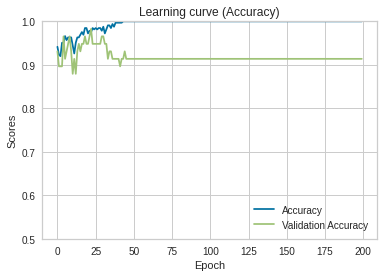

In [124]:
plt.figure(figsize=(6, 4))
plt.title("Learning curve (Accuracy)")
plt.plot(history.history['accuracy'], label='Accuracy')
plt.plot(history.history['val_accuracy'], label = 'Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Scores')
plt.ylim([0.5, 1])
plt.legend(loc='lower right')
plt.show() # Necessary to track plot with ClearML

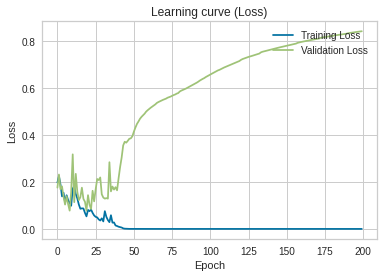

In [125]:
plt.figure(figsize=(6, 4))
plt.title("Learning curve (Loss)")
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label = 'Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend(loc='upper right')
plt.show() # Necessary to track plot with ClearML

In [126]:
model.evaluate(X_test,  y_test, verbose=1)

3/3 [==============================] - 1s 4ms/step - loss: 1.7490 - auc: 0.9367 - accuracy: 0.9271 - precision: 0.9271 - recall: 0.9271


[1.7489938735961914,
 0.9367404580116272,
 0.9270833134651184,
 0.9270833134651184,
 0.9270833134651184]